<a href="https://colab.research.google.com/github/smenaaliaga/tesis_magister/blob/main/data_mimic_iv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracción de datos para tesis magister, MIMIC-IV

## Autentificación Google Colab

In [47]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [48]:
from google.cloud import bigquery
# Declaración de Project ID
project_id = 'mimic-356201'
client = bigquery.Client(project=project_id)

## Exploración MIMIC IV



In [49]:
import pandas as pd
import numpy as np

In [50]:
client.query('''
SELECT count(*) as total
FROM `physionet-data.mimiciv_hosp.admissions`
''').to_dataframe()

,total
0,454324


In [51]:
client.query('''
SELECT count(*) as total
FROM `physionet-data.mimiciv_hosp.patients`
''').to_dataframe()

,total
0,315460


In [52]:
diagnoses = client.query('''
SELECT *
FROM `physionet-data.mimiciv_hosp.d_icd_diagnoses`
''').to_dataframe()

diagnoses.shape

(109775, 3)

In [53]:
diagnoses.head()

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


In [54]:
diagnoses.groupby(['icd_version']).count()

,icd_code,long_title
icd_version,,
9,14666,14666
10,95109,95109


In [55]:
diagnoses.loc[(diagnoses['icd_version'] == 9) & (diagnoses['icd_code'].isin(['99591', '99592', '78552'])), ['icd_code','long_title']]

,icd_code,long_title
9367,78552,Septic shock
12078,99591,Sepsis
12079,99592,Severe sepsis


# Extracción de data

## Datos de Supervivencia y Demografia del Paciente

In [56]:
patients = client.query('''
SELECT a.*, gender, anchor_age, anchor_year, anchor_year_group, dod
FROM `physionet-data.mimiciv_hosp.admissions` a
INNER JOIN `physionet-data.mimiciv_hosp.diagnoses_icd` b
ON a.subject_id = b.subject_id AND a.hadm_id = b.hadm_id
# Extracción de admisiones por Sepsis-3 en su diagnostico
INNER JOIN
(
  SELECT a.subject_id, a.hadm_id, min(c.seq_num) priority
  FROM `physionet-data.mimiciv_hosp.admissions` a
  # Extracción de la última admisión de cada paciente
  INNER JOIN
  (
    SELECT subject_id, MAX(admittime) as max_admittime
    FROM `physionet-data.mimiciv_hosp.admissions`
    GROUP BY subject_id
  ) b ON a.subject_id = b.subject_id AND a.admittime = b.max_admittime
  INNER JOIN `physionet-data.mimiciv_hosp.diagnoses_icd` c
  ON a.subject_id = c.subject_id AND a.hadm_id = c.hadm_id
  # Código ICD-9 de 99591 (sepsis), 99592 (sepsis grave) y 78552 (shock séptico)
  WHERE c.icd_code in ('99591', '99592', '78552')
  GROUP BY a.subject_id, a.hadm_id
) c ON a.subject_id = c.subject_id AND a.hadm_id = c.hadm_id AND b.seq_num = c.priority
# Cruce con data demografica del paciente y muerte extra-hospitalaria (v2.0)
INNER JOIN `physionet-data.mimiciv_hosp.patients` d
ON a.subject_id = d.subject_id
''').to_dataframe()

patients.shape

(3939, 20)

In [57]:
patients.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10377695,28519467,2153-11-07 03:31:00,2153-11-07 10:30:00,2153-11-07 13:37:00,EU OBSERVATION,EMERGENCY ROOM,None,Medicare,ENGLISH,WIDOWED,UNKNOWN,2153-11-07 02:31:00,2153-11-07 04:31:00,1,F,91,2153,2014 - 2016,2153-11-07
1,10691939,20210177,2163-08-07 00:41:00,2163-08-07 17:00:00,NaT,EW EMER.,EMERGENCY ROOM,OTHER FACILITY,Medicare,ENGLISH,MARRIED,WHITE,2163-08-06 22:57:00,2163-08-07 03:15:00,0,F,83,2163,2011 - 2013,None
2,12239697,27026495,2166-11-12 04:06:00,2166-11-15 17:49:00,NaT,EW EMER.,EMERGENCY ROOM,ASSISTED LIVING,Medicare,ENGLISH,None,UNKNOWN,2166-11-12 00:36:00,2166-11-12 06:21:00,0,M,66,2166,2014 - 2016,2167-02-01
3,12652268,22233557,2169-07-03 15:12:00,2169-07-04 01:17:00,2169-07-04 01:17:00,AMBULATORY OBSERVATION,PROCEDURE SITE,None,Medicare,ENGLISH,MARRIED,WHITE,NaT,NaT,1,M,74,2169,2011 - 2013,2169-07-04
4,13110963,22039000,2128-05-06 15:54:00,2128-05-08 10:30:00,NaT,EW EMER.,EMERGENCY ROOM,AGAINST ADVICE,Medicare,?,WIDOWED,WHITE - RUSSIAN,2128-05-06 13:50:00,2128-05-06 17:16:00,0,F,91,2123,2008 - 2010,2128-05-08


### Tabla temporal ID pacientes

In [83]:
client.query('''
DROP TABLE `mimic-356201.temps.temp_patients_hadm`;
''')

client.query('''
CREATE TABLE 
   `mimic-356201.temps.temp_patients_hadm`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 3 DAY)
) AS
SELECT a.subject_id, a.hadm_id, CAST(dischtime AS DATE) AS dischtime
FROM `physionet-data.mimiciv_hosp.admissions` a
INNER JOIN `physionet-data.mimiciv_hosp.diagnoses_icd` b
ON a.subject_id = b.subject_id AND a.hadm_id = b.hadm_id
INNER JOIN
(
  SELECT a.subject_id, a.hadm_id, min(c.seq_num) priority
  FROM `physionet-data.mimiciv_hosp.admissions` a
  INNER JOIN
  (
    SELECT subject_id, MAX(admittime) as max_admittime
    FROM `physionet-data.mimiciv_hosp.admissions`
    GROUP BY subject_id
  ) b ON a.subject_id = b.subject_id AND a.admittime = b.max_admittime
  INNER JOIN `physionet-data.mimiciv_hosp.diagnoses_icd` c
  ON a.subject_id = c.subject_id AND a.hadm_id = c.hadm_id
  WHERE c.icd_code in ('99591', '99592', '78552')
  GROUP BY a.subject_id, a.hadm_id
) c ON a.subject_id = c.subject_id AND a.hadm_id = c.hadm_id AND b.seq_num = c.priority
INNER JOIN `physionet-data.mimiciv_hosp.patients` d
ON a.subject_id = d.subject_id;
''')

## Datos de examenes de Laboratorios

In [103]:
lab = client.query('''
SELECT * FROM
(
SELECT a.subject_id, a.hadm_id, b.label, valuenum
FROM `physionet-data.mimiciv_hosp.labevents` a
INNER JOIN `physionet-data.mimiciv_hosp.d_labitems` b ON a.itemid = b.itemid
INNER JOIN `mimic-356201.temps.temp_patients_hadm` c ON a.subject_id = c.subject_id AND a.hadm_id = c.hadm_id
WHERE charttime BETWEEN c.dischtime AND DATE_ADD(c.dischtime, INTERVAL 1 DAY)
)
PIVOT
(
  -- #2 Aggregate
  AVG(valuenum) AS AVG
  -- #3 Pivot Column
  FOR label in (
    'White Blood Cells' AS WBC,               -- Glóbulos blancos (WBC) --- * *
    'Red Blood Cells' AS RBC,                 -- Glóbulos rojos (RBC)
    'Hemoglobin',                             -- Hemoglobina --- *
    'Hematocrit',                             -- Hematocrito --- * *
    'RDW',                                    -- Ancho de distribución de glóbulos rojos (RDW) --- *
    'MCH',                                    -- Hemoglobina corpuscular media (MCH)
    'MCHC',                                   -- Concentración media de hemoglobina corpuscular (MCHC)
    'MCV',                                    -- Volumen corpuscular medio (MCV)
    'Platelet Count' AS Platelet,             -- Recuento de plaquetas (PLT) --- * *
    'PT',                                     -- Tiempo de protrombina (PT)
    'PTT',                                    -- Tiempo parcial de tromboplastina (PTT)
    'INR(PT)' AS INRPT,                       -- INR PT
    'Lactate',                                -- Lactato --- *
    'Calculated Total CO2' AS C02Total,       -- CO2 total (C02Total)
    'pH',                                     -- pH --- *
    'pO2',                                    -- PaO2
    'Alanine Aminotransferase (ALT)' AS ALT,  -- Alanina aminotransferasa (ALT)
    'Asparate Aminotransferase (AST)' AS AST, -- Aspartato aminotransferasa (AST)
    'Albumin',                                -- Albúmina --- * *
    'Phosphate' AS AP,                        -- Fosfatasa Alcalina (AP)
    'Bilirubin, Total' AS Bilirubin,          -- Bilirrubina total --- * *
    'Urea Nitrogen' AS BUN,                   -- Nitrógeno ureico (BUN)
    'Creatinine',                             -- Creatinina --- *
    'Glucose',                                -- Glucosa
    'Anion Gap' AS AG,                        -- Brecha aniónica, glucosa  (AG)
    'Base Excess' AS EB,                      -- Exceso de base (EB)
    'Calcium, Total' AS CaTotal,              -- Calcio total (CaTotal)
    'Chloride',                               -- Cloruro
    'Bicarbonate',                            -- Micarbonato
    'Phosphate',                              -- Fosfato
    'Potassium',                              -- Potasio --- * *
    'Sodium'                                  -- Sodio --- * *
    )
)
''').to_dataframe()

lab.shape

(2643, 34)

In [86]:
lab.head()

,subject_id,hadm_id,AVG_WBC,AVG_RBC,AVG_venti,AVG_Hemoglobin,AVG_Hematocrit,AVG_RDW,AVG_MCH,AVG_MCHC,...,AVG_Creatinine,AVG_Glucose,AVG_AG,AVG_EB,AVG_CaTotal,AVG_Chloride,AVG_Bicarbonate,AVG_Phosphate,AVG_Potassium,AVG_Sodium
0,10422844,26400469,28.40,3.520,None,9.90,31.6,14.2,28.10,31.20,...,4.0,132.666667,36.0,-7.000000,9.6,100.333333,18.0,9.966667,6.533333,148.0
1,11058564,22303038,NaN,NaN,None,NaN,40.8,NaN,NaN,NaN,...,NaN,304.000000,NaN,-20.333333,7.4,NaN,NaN,10.200000,NaN,NaN
2,11235409,20756799,11.20,4.030,None,13.20,39.0,13.9,32.70,33.80,...,NaN,427.000000,NaN,-5.000000,NaN,NaN,NaN,2.300000,NaN,NaN
3,11697323,28846818,5.25,2.185,None,6.95,20.7,20.3,31.75,33.55,...,2.1,153.000000,16.0,0.000000,9.1,126.500000,24.0,3.000000,2.500000,151.0
4,12119555,21909650,1.70,1.630,None,4.40,15.7,21.5,27.00,28.10,...,1.1,181.000000,28.0,-23.000000,6.9,106.000000,7.0,7.400000,5.200000,136.0


## Datos de Signos Vitales

In [62]:
vital = client.query('''
SELECT * FROM
(
SELECT a.subject_id, a.hadm_id, b.label, valuenum
FROM `physionet-data.mimiciv_icu.chartevents` a
INNER JOIN `physionet-data.mimiciv_icu.d_items` b ON a.itemid = b.itemid
INNER JOIN `mimic-356201.temps.temp_patients_hadm` c ON a.subject_id = c.subject_id AND a.hadm_id = c.hadm_id
WHERE charttime BETWEEN c.dischtime AND DATE_ADD(c.dischtime, INTERVAL 1 DAY)
)
PIVOT
(
  -- #2 Aggregate
  AVG(valuenum) AS AVG
  -- #3 Pivot Column
  FOR label in (
      'Heart Rate' AS HR,                           -- Frecuencia cardíaca media
      'Arterial Blood Pressure systolic' AS ABPs,   -- Presión arterial sistólica media
      'Arterial Blood Pressure diastolic' AS ABPd,  -- Presión arterial diastólica media
      'Arterial Blood Pressure mean' AS ABPm,       -- Presión arterial media
      'Temperature Celsius' AS Tc,                  -- Temperatura media
      'Respiratory Rate' AS RR,                     -- Frecuencia Respiratoria
      'GCS - Eye Opening' AS GCSep,                 -- Glasgow - Eye Opening
      'GCS - Verbal Response' AS GCSvr,             -- Glasgow - Verbal Response
      'GCS - Motor Response' AS GCSmr               -- Glasgow - Motor Response
    )
)
''').to_dataframe()

vital.shape

(1530, 11)

In [63]:
vital.head()

,subject_id,hadm_id,AVG_HR,AVG_ABPs,AVG_ABPd,AVG_ABPm,AVG_Tc,AVG_RR,AVG_GCSep,AVG_GCSvr,AVG_GCSmr
0,19869246,21565952,106.000000,NaN,NaN,NaN,NaN,20.333333,3.0,1.0,6.0
1,15925315,28518389,101.058824,NaN,NaN,NaN,NaN,28.176471,3.0,1.0,5.0
2,10032381,20176432,93.812500,NaN,NaN,NaN,NaN,25.000000,4.0,4.0,6.0
3,19273327,27624994,105.478261,NaN,NaN,NaN,NaN,29.130435,2.0,2.0,4.0
4,16665617,24237377,98.360000,84.851852,54.518519,65.925926,NaN,29.740741,1.0,1.0,1.0


# Manipulación del Dataframe

In [104]:
import pandas as pd
import numpy as np

## Obtener tiempos de supervivencia

In [105]:
# Transformación de Datetime (Fecha-Hora) a Date (Fecha)
patients['admittime'] = pd.to_datetime(patients['admittime']).dt.date
patients['dischtime'] = pd.to_datetime(patients['dischtime']).dt.date
patients['deathtime'] = pd.to_datetime(patients['deathtime']).dt.date

Variables de fechas importantes para el análisis de supervivencia:

- admittime: Fecha en que el paciente fue admitido en el hospital
- dischtime: Fecha en que el paciente fue dado de alta del hospital
- deathtime: Fecha de la muerte hospitalaria del paciente. Casi siempre la dischtime es igual a deathtime, las diferencias pueden ser ocasionadas por errores tipograficos
- dod: En la versión 2.0 de MIMIC-IV se introduce la fecha de muerte extra-hospitalaria para algunos pacientes.

In [106]:
patients.loc[:, ['subject_id', 'admittime', 'dischtime', 'deathtime', 'dod']]

,subject_id,admittime,dischtime,deathtime,dod
0,10377695,2153-11-07,2153-11-07,2153-11-07,2153-11-07
1,10691939,2163-08-07,2163-08-07,NaT,None
2,12239697,2166-11-12,2166-11-15,NaT,2167-02-01
3,12652268,2169-07-03,2169-07-04,2169-07-04,2169-07-04
4,13110963,2128-05-06,2128-05-08,NaT,2128-05-08
...,...,...,...,...,...
3934,18601357,2155-04-22,2155-05-27,NaT,2155-06-03
3935,14723793,2149-05-01,2149-08-01,NaT,None
3936,16644289,2124-06-23,2124-08-14,NaT,2124-08-25
3937,17165725,2138-03-26,2138-04-02,NaT,2139-03-18


Se define __endtime__ mediante la siguiente regla:

1. Si _dod_ no es nulo, _endtime_ = _dod_ (muerte extra-hospitalaria), de lo contrario:

2. Si _dischtime_ no es nulo, _endtime_ = _dischtime_ (muerte intra-hospitalaria), de lo contrario:

3. _endtime_ = _dischtime_ (censura a la derecha).

In [107]:
patients['endtime'] = np.where(
    patients['dod'].notnull(), patients['dod'], np.where(
    patients['deathtime'].notnull(), patients['deathtime'], patients['dischtime'])) 

In [108]:
patients.loc[:, ['subject_id', 'admittime', 'dischtime', 'deathtime', 'dod', 'endtime']]

,subject_id,admittime,dischtime,deathtime,dod,endtime
0,10377695,2153-11-07,2153-11-07,2153-11-07,2153-11-07,2153-11-07
1,10691939,2163-08-07,2163-08-07,NaT,None,2163-08-07
2,12239697,2166-11-12,2166-11-15,NaT,2167-02-01,2167-02-01
3,12652268,2169-07-03,2169-07-04,2169-07-04,2169-07-04,2169-07-04
4,13110963,2128-05-06,2128-05-08,NaT,2128-05-08,2128-05-08
...,...,...,...,...,...,...
3934,18601357,2155-04-22,2155-05-27,NaT,2155-06-03,2155-06-03
3935,14723793,2149-05-01,2149-08-01,NaT,None,2149-08-01
3936,16644289,2124-06-23,2124-08-14,NaT,2124-08-25,2124-08-25
3937,17165725,2138-03-26,2138-04-02,NaT,2139-03-18,2139-03-18


In [109]:
# Se define el booleano "died" si es que el evento de la muerte del paciente ha ocurrido

patients['died'] = np.where(patients['dod'].isnull(), np.where(patients['deathtime'].isnull(), False, True), True)

In [110]:
patients.loc[:, ['subject_id', 'admittime', 'dischtime', 'deathtime', 'dod', 'endtime', 'died']]

,subject_id,admittime,dischtime,deathtime,dod,endtime,died
0,10377695,2153-11-07,2153-11-07,2153-11-07,2153-11-07,2153-11-07,True
1,10691939,2163-08-07,2163-08-07,NaT,None,2163-08-07,False
2,12239697,2166-11-12,2166-11-15,NaT,2167-02-01,2167-02-01,True
3,12652268,2169-07-03,2169-07-04,2169-07-04,2169-07-04,2169-07-04,True
4,13110963,2128-05-06,2128-05-08,NaT,2128-05-08,2128-05-08,True
...,...,...,...,...,...,...,...
3934,18601357,2155-04-22,2155-05-27,NaT,2155-06-03,2155-06-03,True
3935,14723793,2149-05-01,2149-08-01,NaT,None,2149-08-01,False
3936,16644289,2124-06-23,2124-08-14,NaT,2124-08-25,2124-08-25,True
3937,17165725,2138-03-26,2138-04-02,NaT,2139-03-18,2139-03-18,True


In [111]:
# Se obtienen los días de supervivencia de los pacientes

patients['survival_days'] = (patients['endtime'] - patients['admittime']).dt.days

In [112]:
patients.loc[:, ['subject_id', 'admittime', 'endtime', 'survival_days', 'died']]

,subject_id,admittime,endtime,survival_days,died
0,10377695,2153-11-07,2153-11-07,0,True
1,10691939,2163-08-07,2163-08-07,0,False
2,12239697,2166-11-12,2167-02-01,81,True
3,12652268,2169-07-03,2169-07-04,1,True
4,13110963,2128-05-06,2128-05-08,2,True
...,...,...,...,...,...
3934,18601357,2155-04-22,2155-06-03,42,True
3935,14723793,2149-05-01,2149-08-01,92,False
3936,16644289,2124-06-23,2124-08-25,63,True
3937,17165725,2138-03-26,2139-03-18,357,True


### Selección de subconjunto de pacientes

In [113]:
# Se filtran los pacientes con más de un día de supervivencia y menos de 1 año, y sean mayores de 16 años

data = patients[(patients['survival_days'] > 1) & (patients['survival_days'] <= 365) & (patients['anchor_age'] >= 16)]
data.shape

(3591, 23)

## Selección de características paciente

In [114]:
data.columns.values.tolist()

['subject_id',
 'hadm_id',
 'admittime',
 'dischtime',
 'deathtime',
 'admission_type',
 'admission_location',
 'discharge_location',
 'insurance',
 'language',
 'marital_status',
 'race',
 'edregtime',
 'edouttime',
 'hospital_expire_flag',
 'gender',
 'anchor_age',
 'anchor_year',
 'anchor_year_group',
 'dod',
 'endtime',
 'died',
 'survival_days']

In [115]:
data = data.loc[:, ['subject_id', 'survival_days', 'died', 'hadm_id', 'gender', 'anchor_age', 'race']]
data.head()

,subject_id,survival_days,died,hadm_id,gender,anchor_age,race
2,12239697,81,True,27026495,M,66,UNKNOWN
4,13110963,2,True,22039000,F,91,WHITE - RUSSIAN
5,13657153,7,False,26430773,M,59,AMERICAN INDIAN/ALASKA NATIVE
7,14227792,3,False,29835792,F,60,WHITE
8,14972735,6,False,27715230,F,79,BLACK/AFRICAN AMERICAN


### Left Join con data laboratorio y signos vitales

In [116]:
data = data.merge(lab, on=['subject_id', 'hadm_id'], how='left', suffixes=None)
data = data.merge(vital, on=['subject_id', 'hadm_id'], how='left', suffixes=None)
data.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' as a <class 'NoneType'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  validate=validate,


(3591, 48)

In [117]:
data.columns.values.tolist()

['subject_id',
 'survival_days',
 'died',
 'hadm_id',
 'gender',
 'anchor_age',
 'race',
 'AVG_WBC',
 'AVG_RBC',
 'AVG_Hemoglobin',
 'AVG_Hematocrit',
 'AVG_RDW',
 'AVG_MCH',
 'AVG_MCHC',
 'AVG_MCV',
 'AVG_Platelet',
 'AVG_PT',
 'AVG_PTT',
 'AVG_INRPT',
 'AVG_Lactate',
 'AVG_C02Total',
 'AVG_pH',
 'AVG_pO2',
 'AVG_ALT',
 'AVG_AST',
 'AVG_Albumin',
 'AVG_AP',
 'AVG_Bilirubin',
 'AVG_BUN',
 'AVG_Creatinine',
 'AVG_Glucose',
 'AVG_AG',
 'AVG_EB',
 'AVG_CaTotal',
 'AVG_Chloride',
 'AVG_Bicarbonate',
 'AVG_Phosphate',
 'AVG_Potassium',
 'AVG_Sodium',
 'AVG_HR',
 'AVG_ABPs',
 'AVG_ABPd',
 'AVG_ABPm',
 'AVG_Tc',
 'AVG_RR',
 'AVG_GCSep',
 'AVG_GCSvr',
 'AVG_GCSmr']

### Export data

In [118]:
from google.colab import files

data.to_csv('data_tesis.csv')
files.download('data_tesis.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Selección de variables predictoras

In [119]:
data_y = data.loc[:, ['survival_days', 'died']]
data_y.head()

,survival_days,died
0,81,True
1,2,True
2,7,False
3,3,False
4,6,False


# Sckit-Survival

In [120]:
pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 25.2 MB/s 


## Estimador Kaplan-Meier

Text(0.5, 0, 'days')

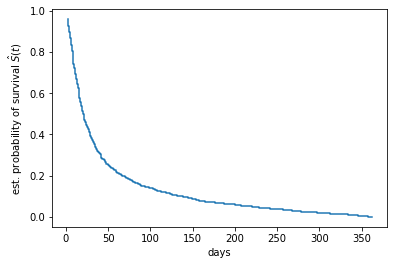

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["died"], data_y["survival_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("days")

## Estimador Nelson-Aalen

### Función de Riesgo Acumulativo

Text(0.5, 0, 'days')

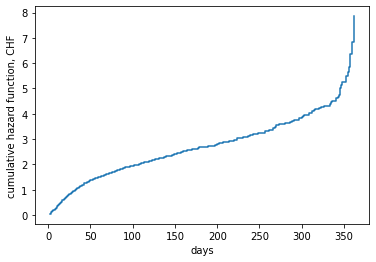

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import nelson_aalen_estimator

time, survival_chf = nelson_aalen_estimator(data_y["died"], data_y["survival_days"])
plt.step(time, survival_chf, where="post")
plt.ylabel("cumulative hazard function, CHF")
plt.xlabel("days")

### Función de Supervivencia

Text(0.5, 0, 'days')

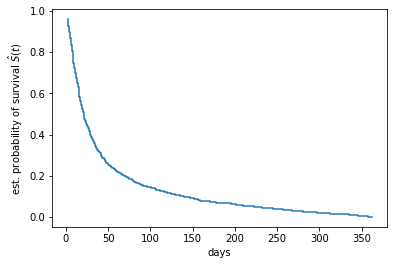

In [123]:
%matplotlib inline

survival_prob = np.exp(-survival_chf)
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("days")